# Week 4: Evaluation Metrics

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import List
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from week_4_functions import *
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
url = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'

In [4]:
churn_data = fetch_data(url)
df = data_cleaning_pipeline(churn_data)

In [5]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [6]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
       'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection',
       'techsupport', 'streamingtv', 'streamingmovies',
       'contract', 'paperlessbilling', 'paymentmethod']

In [7]:
x_train, t_vec_enc = one_hot_encoding(df_train, categorical + numerical)
x_val, v_vec_enc = one_hot_encoding(df_val, categorical + numerical)

In [8]:
model = LogisticRegression()
model.fit(x_train, y_train)

LogisticRegression()

In [9]:
y_pred = model.predict_proba(x_val)[:, 1]
churn_decision = y_pred >= 0.5
churn_decision.astype(int)
(y_val == churn_decision).mean()

0.8034066713981547

## Accuracy and dummy model

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


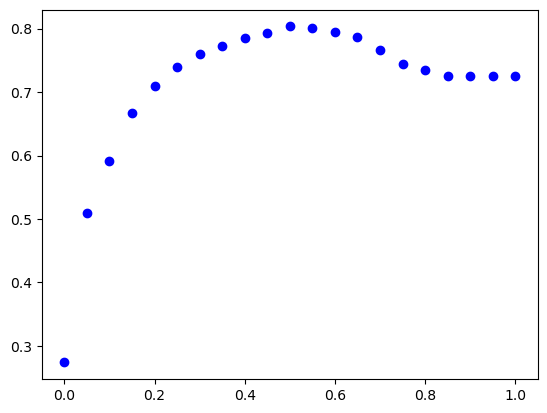

In [10]:
thresholds = np.linspace(0, 1, 21)

for t in thresholds:
    churn_decision = y_pred >= t
    acc = (y_val == churn_decision).mean()
    print('%.2f %.3f' % (t, acc))
    plt.plot(t, acc, 'bo')

In [11]:
from sklearn.metrics import accuracy_score

accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

## Confusion table

In [12]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()


In [13]:
# sklearn confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_val, y_pred >= 0.5)

array([[922, 101],
       [176, 210]], dtype=int64)

## Precision and recall

Precision: fraction of positive predictions turned out to be correct. True positive predictions divided by all positive predictions.

In [14]:
precision = tp / (tp + fp)
precision

0.6752411575562701

Recall: fraction of correctly identified positive examples. 

In [15]:
recall = tp / (tp + fn)
recall

0.5440414507772021

Recall and precision are a significantly more informative metrics than accuracy. Here the value of recall indicates that our model failed to identify 46% of the positive examples and incorrectly labelled 33% of the negative examples as positive.

The precision metric examines the cases that our model predicts to be correct and considers the fraction of these cases where the prediction in correct. Conversely, recall examines the cases that are actually correct and considers the fraction of these cases that our model predicts to be correct.

## ROC Curves

In [16]:
tpr = tp / (tp + fn)

fpr = fp / (fp + tn)

print(f"tpr: {tpr}, fpr: {fpr}")

tpr: 0.5440414507772021, fpr: 0.09872922776148582


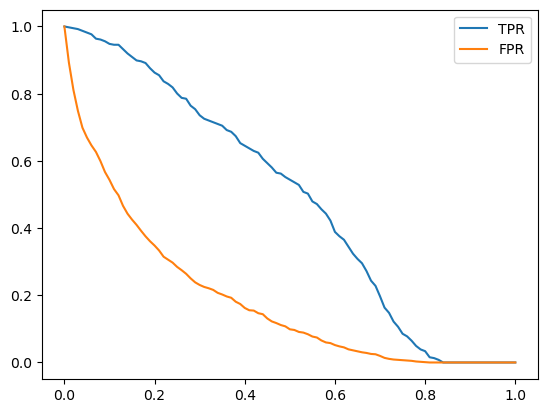

In [17]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))

df_scores = pd.DataFrame(scores)
df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

# df_scores 

## Random model

In [18]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))
y_rand

array([4.17022005e-01, 7.20324493e-01, 1.14374817e-04, ...,
       7.73916250e-01, 3.34276405e-01, 8.89982208e-02])

In [19]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

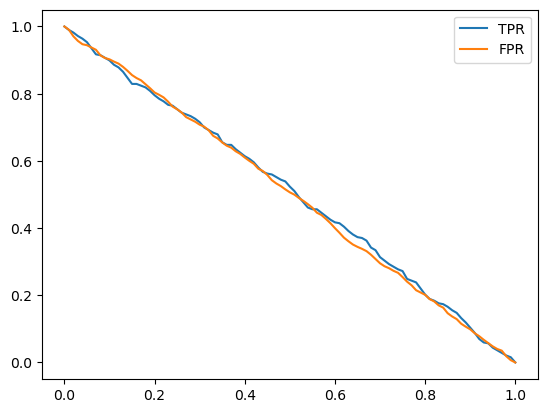

In [20]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    df_scores = pd.DataFrame(scores)
    df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    return df_scores

df_rand = tpr_fpr_dataframe(y_val, y_rand)

plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

Text(0.5, 1.0, 'ROC curve')

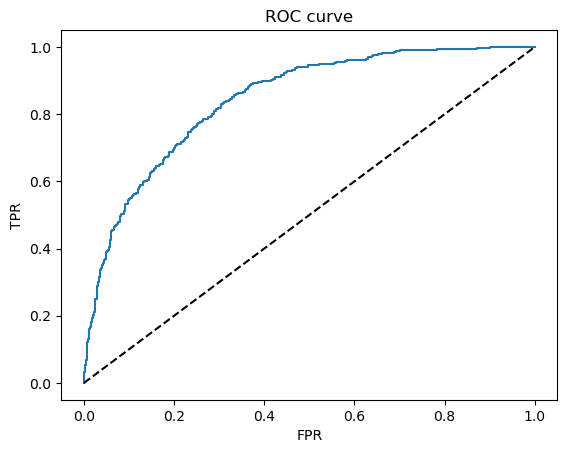

In [21]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle='--', color='k')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')


## AUC: Area under the curve

In [22]:
from sklearn.metrics import auc
auc(fpr, tpr)

0.843850505725819

In [23]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred)

0.843850505725819

In [72]:
def train(train_df: pd.DataFrame, y_train: np.array) -> LogisticRegression:

    if len(train_df) != len(y_train):
        min_length = min(len(train_df), len(y_train))
        train_df = train_df[:min_length]
        y_train = y_train[:min_length]
    
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X = dv.fit_transform(dicts)
    
    model = LogisticRegression()
    # assert len(X) == len(y_train)
    model.fit(X, y_train)

    return dv, model

def predict(df: pd.DataFrame, dv: DictVectorizer, model: LogisticRegression) -> np.array:
    dicts = df[categorical + numerical].to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred

def get_kfolds(df: pd.DataFrame, n_splits: int) -> np.array:
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    train_idx, val_idx = next(kfold.split(df_full_train))
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    return df_train, df_val


def train_on_kfolds(df_full_train: pd.DataFrame, n_splits: int) -> np.array:
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    for train_idx, val_idx in kfold.split(df_full_train):

        print(len(train_idx), len(val_idx))
        df_train_i = df_full_train.iloc[train_idx]
        print(len(df_train))
        df_val = df_full_train.iloc[val_idx]
        
        y_train = df_train.churn.values
        print(len(y_train))
        y_val = df_val.churn.values
        assert len(y_train) == len(df_train)
        dv, model = train(df_train_i, y_train)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        print('auc: %.3f' % auc, train_idx, val_idx)

train_on_kfolds(df_full_train, 6)

# dv, model = train(df_train, y_train)
# y_pred = predict(df_val, dv, model)
# df_train, df_val = get_kfolds(df_full_train, 5)

4695 939
5071
5071


ValueError: Found input variables with inconsistent numbers of samples: [5071, 4695]

In [46]:
len(y_train), len(df_train)

(5071, 5071)

In [54]:
scores = []

kfold = KFold(n_splits=10, shuffle=True, random_state=1)
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train.churn.values
    y_val = df_val.churn.values
    assert len(y_train) == len(df_train)
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

c:\Users\rhys-\anaconda3\envs\loll\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\rhys-\anaconda3\envs\loll\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

In [55]:
scores

[0.8479398247539081,
 0.8410272277227723,
 0.8557048652060528,
 0.8341947164842399,
 0.8269851116625311,
 0.8342657342657342,
 0.8412569195701727,
 0.8186669829222013,
 0.8455165258633466,
 0.8616012907129171]

In [74]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [75]:
from tqdm.auto import tqdm

n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.825 +- 0.009
C=0.01 0.840 +- 0.009
C=0.1 0.841 +- 0.007
C=0.5 0.840 +- 0.007
C=1 0.841 +- 0.008
C=5 0.841 +- 0.008
C=10 0.841 +- 0.007


In [76]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8572386167896259